---
<div style="text-align:center; font-family:verdana;">
    <h1><strong>Simulación numérica del sistema de elución y
filtrado de una planta de extracción</strong></h1>
    <br>
    <br>
    <br>
    <div>
        Autor
        <h2>Juan David Argüello Plata</h2>
        Ingeniero mecánico
    </div>
    <br>
    <br>
    <br>
    <i>Tesis de maestría en investigación para optar al título de maestro en ciencias en ingeniería mecánica</i>
    <br>
    <br>
    <br>
    <br>
    <div>
        Director
        <h2>Omar Armando Gélvez Arocha</h2>
        Ingeniero mecánico <i>M.Sc.</i>
    </div>
    <br>
    <br>
    <br>
    <br>
    <strong style="font-size:140%;">Universidad Industrial de Santander</strong>
    <br>
    Facultad de ingenierías físicomecanicas
    <br>
    Escuela de ingeniería mecánica
    <br>
    Maestría en ingeniería mecánica
    <br>
    2020
</div>

---

<h2 style="text-align:center"><strong>Resumen</strong></h2>
<div style="text-align:justify">
    El proceso de extracción basado en el método de dispersión de la matriz en fase sólida, MSPD, consiste de <strong>tres etapas</strong>. La primera es la <i>etapa de pretratamiento</i>, o de molienda, en donde se busca disminuir el tamaño de partícula del material orgánico con el fin de incrementar el área de transferencia de masa. La siguiente se trata de la <i>etapa de elución y filtrado</i>, en donde se produce la extracción de metabolitos secundarios a través de un solvente; luego, se filtra el material particulado para obtener la mezcla homogénea solvente - extracto. Finalmente, se desarrolla una <i>etapa de separación de sustancias</i>, en donde se separa el solvente del extracto (producto final).
    <br>
    <br>
    Se propone una metodología de diseño automático del sistema de elución y filtrado que simule el comportamiento fluidodinámico durante la etapa de filtrado, permitiendo predecir el grado de concentración de partículas a lo largo del sistema a través de un modelo numérico basado en CFD-DEM. Esta metodología ha sido elaborada con herramientas de código abierto. Utilizando <i>Python</i> como lenguaje base, <i>Jupyter</i> como entorno de desarrollo, <i>ParaView</i> como plataforma de análisis de resultados y librerías de <i>C++</i> (como Yade, LIGGGHTS y OpenFoam) para el desarrollo de las simulaciones numéricas.
</div>

<br>

___Palabras clave:___ CFD-DEM, MSPD, Python, Jupyter, ParaView, OpenFoam, Yade.

---

# __1. Introducción__

<div style="text-align: justify">
    Los métodos numéricos son teoremas matemáticos que permiten describir la naturaleza de diferentes fenómenos de carácter físico-químico. Son ampliamente usados en ingeniería como metodologías predictivas durante el proceso de diseño funcional
y mecánico. Para el análisis de comportamientos fluidodinámicos de partículas, es común encontrar estudios que combinen los métodos numéricos de <i>elementos discretos</i> y <i>volúmenes finitos</i>, o como es mejor conocido: <i>modelo CFD-DEM</i>.
    <br>
    <br>
    El acoplamiento entre CFD-DEM se ha empleado cuando se busca desarrollar análisis de partículas y su interacción en medios viscosos. Ampliamente usado para análisis de lecho fluidizado[9], separadores de ciclón (Chu et al., 2009) y para el estudio de retención de partículas en medios filtrantes[10], por citar algunos ejemplos. Se han desarrollado estudios experimentales que corroboran la efectividad y viabilidad de las simulaciones numéricas que emplean CFD-DEM[9, 11]. 
    <br>
    <br>
    En el acoplamiento clásico entre CFD-DEM, el flujo se resuelve a través del método CFD basado en malla, mientras que la fase sólida es modelada mediante DEM para cada partícula sujeta a través de fuerzas hidrodinámicas, fuerzas de cuerpo (como la gravedad) y a través de fuerzas de contacto, actualizando valores de velocidad y posición conforme a la segunda ley de Newton (Hoomans et al., 1996; Tsuji et al., 1993; Xu y Yu, 1997). En principio, todos los métodos CFD pueden acoplarse con DEM; lo que ha dado origen a diferentes métodos discretos y continuos, tal como el método de Lattice Boltzmann (LBM), Hidrodinámica de Partículas Suaves (SPH), métodos de Diferencias Finitas y Volúmenes Finitos (FVM).
    <br>
    <br>
    Gran parte de las simulaciones reportadas en la literatura comprenden modelos 2D o sistemas prototipados de pequeña escala. En busca de acelerar los tiempos de simulación e incrementar la eficiencia computacional, se han desarrollado técnicas de computación paralela; donde gran parte de los esfuerzos han sido enfocados en la paralelización del DEM. Muchos algoritmos se han propuesto para lograr este hecho, como la técnica de espejo de dominio (Damana, et al., 2006; Washington y Meegoda, 2003), el método de subconjunto de partículas (Kafui et al., 2011) y
métodos de descomposición de dominios (Amritkar et al., 2014; Tsuji et al., 2008). El uso de estos algoritmos depende de la arquitectura del hardware. La paralelización sobre memoria compartida del sistema se alcanza, normalmente, empleando OpenMP (“Open Multi-Processing”, por sus siglas en inglés), mientras que el MPI (Interfaz de Paso de Mensajes) se emplea en sistemas de memoria distirbuida (Rabenseifner et al., 2009). Por ejemplo, Tsuji et al. (2008) paralelizaron una simulación en CFD-DEM usando MPI para el intercambio de información entre 16 CPUs, reportando el comportamiento fluidodinámico de 4.5 millones de partículas en un medio gaseoso; empleando el método unidimensional de descomposición de dominio.
</div>

# __2. Método de dispersión de la matriz en fase sólida - MSPD__

<div style="text-align: justify">
    Se trata de un método de extracción ampliamente utilizado para el estudio de muestras biológicas. Existen más de 250 publicaciones en las que se emplea este método extractivo para el análisis de extractos de distintas naturalezas [3]. Esto se debe a la alta eficiencia y bajo costo del método de extracción.
    <br>
    <br>
    El método consiste, básicamente, de tres etapas (como se puede observar en la Figura 1):
</div>

1. Maceración de la muestra con un agente dispersante (material particulado, normalmente compuesto de sílice).
2. Elución con solvente y filtrado de la mezcla solvente - extracto.
3. Separación de la mezcla solvente extracto mediante técnicas de evaporación al vacío, que permiten la reutilización del solvente en procesos de extracción posteriores.

<div align="center">
    <img src="Images/mspd.PNG" style="width: 300px;" />
</div>
<div align="center">
    <i>Figura 1.</i> Método MSPD$^{[1]}$.
</div>

## 2.1. Factores a considerar en la extracción MSPD

<div style="text-align:justify">
    Hay varios factores a considerar en la extracción MSPD, que incluye:
</div>

1. _Efecto del tamaño de partícula media:_ tamaños de partícula pequeños (entre $3 - 10 \left[ \mu m \right]$) requiere de grandes tiempos de elución y altos gradientes de presión para obtener un flujo adecuado.
2. _Agente dispersante_: el uso de silicatos infravalorados, como la arena de río, para la maceración de muestras presenta resultados diferentes a los reportados con agentes dispersantes como el $C_{18}$ o el $C_8$. A pesar de que el mismo principio de disrupción de la matriz se conserva, debido a la abrasión, es probable que se de una interacción química no deseada entre silicatos infravalorados y algunos de los flavonoides del extracto.
3. _Relación másica_: la mejor relación másica reportada en la literatura frecuenta ser una relación 1 a 4 [3], aunque puede variar de una aplicación a otra.
4. _Solvente_: el vertimiento del solvente en la columna MSPD tiene el fin de aislar analitos específicos o familias de compuestos. El tipo de solvente, y la polaridad de este, define la composición final del extracto. Existen estudios en donde se ha demostrado un incremento en el rendimiento extractivo al emplear solventes a temperaturas superiores a la temperatura ambiente e inferiores a los $60 [°C]$[8].

# __3. Diseño del sistema__

## 3.1. Generalidades

Se requieren de los siguientes datos:

In [1]:
from App.Generalidades.Data import *
data = Datos()
data

Con base en los datos suministrados, las propiedades termodinámicas del solvente se pueden apreciar a continuación.

In [2]:
from App.Generalidades.Read import Read
from App.Generalidades.Propiedades import *
general = Read(data)
prop = SolProp(general)()
prop = prop['mezcla']

#### _Propiedades termodinámicas de la mezcla agua - etanol al $50[\%] $_
        

| Propiedad | Valor |
|---|---|
| Densidad $[kg / m^3 ]$ | $889.4$ |
| Viscosidad $[kg / m \, s]$ | $1.06 \, 10 ^{-6} $ |
| Relación de densidades | $1.91$ |
        

## 3.2. Naturaleza del flujo

El éxito de un sistema de sedimentación recae en la naturaleza del flujo durante el proceso de separación de sustancias. Siendo necesario que éste sea de carácter laminar para evitar reflujos. 

Asumiendo régimen laminar en la interacción _fluido - partícula_, la velocidad de sedimentación se calcula a través de la siguiente relación matemática.

$$
\begin{equation}
    V_{laminar} = \frac{g}{18} \left(S_s -1 \right) \, \frac{d_{particula} ^2}{\mu}
\end{equation}
$$

Con base en este valor de velocidad, el número de Reynolds se calcula de la siguiente forma:

$$
\begin{equation}
    Re = \frac{V_{laminar} \, d_{particula}}{\mu}
\end{equation}
$$

In [3]:
from App.Sedimentation.Inicial import *
Q = caudal(general['Fluido']['Volumen [L]'], general['Fluido']['Tiempo objetivo [h]'])
res_inicial = ReyLaminar(general, prop, Q)()

La velocidad laminar tiene un valor de: $V_{laminar} = 2.934 [cm/s]$. El número de Reynolds tendría un valor de: $Re = 6.931$ a esta velocidad de flujo. Lo anterior significa que la interacción _fluido - partícula_ se encuentra en __régimen de transición__.
        

## 3.3. Dimensionamiento

El sistema de filtrado se trata de un _equipo sedimentador de placas paralelas_. A continuación, se define la geometría preliminar del panel de lamelas para el diseño del sistema de sedimentación. 

In [4]:
from App.Generalidades.Lamelas import *
geo = Geometry()
geo

In [5]:
from App.Generalidades.Read import *
datos_geo = Read(geo, datos={'lamela':{}})
datos_geo = datos_geo['lamela']
lamela = Flujo_int(datos_geo, general)

El caudal requerido por el sistema es de $Q = 55.556 \left[cm^3 /s \right]$. Con base en la geometría dada, significa que la velocidad del fluido dentro de cada lamela es de $V = 4.444 [cm/min]$.



La velocidad crítica de sedimentación de las partículas se calcula a partir de la fórmula de Yao (Ecuación \ref{yao}).

$$
\begin{equation}
    V_{sc} = \frac{S_c \, V_0}{\sin \theta + L_{rel} \cos \theta}
    \label{yao}
    \tag{1}
\end{equation}
$$

De la Ecuación \ref{yao}, $S_c$ es una cosntante de sedimentación, cuyo valor es 1 para sistemas de placas paralelas, $V_0$ es la magnitud del flujo, $L_{rel}$ es la relación entre la longitud de una lamela y el ancho de la misma; y $\theta$ es el ángulo de inclinación de las placas.

La relación entre el ancho $e$ del conducto y la longitud $L$ tiene una importancia especial en la eficiencia de un sedimentador. Si esta relación $L_{rel}$ es muy pequeña, cada sedimentdor actúa como un sedimentador horizontal de corriente de baja velocidad.

Para que un sedimentador pueda trabajar con alta vleocidad, es necesario que exista flujo laminar en las celdas, esto es que el número de Reynoles sea inferior a 250. Cualquier turbulencia puede generar arrastre de partículas, bajando notoriamente la eficiencia; razón por la que se emplea como criterio principal de diseño.

$$
\begin{equation}
    Re = \frac{4 \, V_0 \, R_h}{\mu}
    \label{Re_def}
    \tag{2}
\end{equation}
$$

En dónde $R_h$ es el radio hidráulico, cuyo valor está definido en la Ecuación \ref{rh}.

$$
\begin{equation}
    R_h = \frac{b \, e}{2 \left(b + e \right)}
    \label{rh}
    \tag{3}
\end{equation}
$$

In [6]:
from App.Sedimentation.ParOper import *
res_oper = Parametros(general, prop, lamela, datos_geo)()

El valor de sedimentación crítica, de acuerdo a la _fórmula de Yao_, es de $V_{sc} = 0.095 \cdot 10^{-3} [cm/s]$. A la velocidad de flujo dada, se tiene un número de Reynolds de $Re = 32.307$, garantizando un flujo laminar en dentro de las lamelas.

## 3.4. Velocidad de sedimentación

Conociendo las propiedades del solvente y del material particulado, se puede calcular la _velocidad de sedimentación_ de las partículas a parti de la Ecuación \ref{Vsed}.

$$
\begin{equation}
    V_{sed} = 0.22 \left(g \frac{\rho _{sol} - \rho _{liq}}{\rho _{liq}} \right) ^{2/3} \frac{d_{part}}{\sqrt[3]{\frac{\mu}{\rho _{liq}}}}
    \label{Vsed}
    \tag{4}
\end{equation}
$$

La eficiencia del sistema se calcula empleando la Ecuación \ref{Ef}.

$$
\begin{equation}
    Ef = 1-\frac{V_{sc}}{V_{sed}}
    \label{Ef}
    \tag{5}
\end{equation}
$$

In [7]:
from App.Sedimentation.Resultados import *
res_sed = Resul(prop, res_oper['V'], general['Solid'] )()

La velocidad de sedimentación de las partículas es de $V_{sed} = 1.502 [cm/s]$. La _eficiencia_ del sistema de filtrado es del $99.367 \%$.

## 3.5. Método de Hazen $\rightarrow$ tiempo de sedimentación

El concepto de carga hidráulica superficial (parámetro de Hazen) compara la
velocidad de sedimentación de la partícula para conocer si alcanza a sedimentarse
durante el trayecto por el sistema. La altura de sedimentación requerida se calcula
mediante la Ecuación \ref{Hsed}.

$$
\begin{equation}
    H_{sedimentacion} = \frac{e}{\cos \theta}
    \label{Hsed}
    \tag{6}
\end{equation}
$$

El tiempo requerido para que la sedimentación se desarrolle se calcula de la siguiente forma:

$$
\begin{equation}
    t_{sed} = \frac{H_{sedimentacion}}{V_{sed}}
    \tag{7}
\end{equation}
$$

In [8]:
Hazen = Tiempo(datos_geo['Ancho lamela [cm]'], datos_geo['Inclinación [°]'], res_sed['V_sed'])()

La altura de sedimentación tiene un valor de $H_{sed} = 5.0 [cm]$. Es debido a ello que el tiempo de sedimentación es de $t_{sed} = 3.33 [s]$.

## 3.6. Resultados

El resumen de resultados obtenidos se pueden apreciar en la siguiente tabla:

In [9]:
TablaResumen(lamela, res_oper, res_sed, Hazen)

| Propiedad | Valor |
|---|---|
| Caudal sistema $[cm^3/s ]$ | 55.56 |
| Vel. flujo lamela $[cm / min]$ | 4.44 |
| Número Reynolds | 32.31 |
| Vel. sedimentación $[cm/min]$ | 90.1 |
| Eficiencia $[\%]$ | 99.37 |
| Tiempo sed. $[s]$ | 3.33 |
        

# __4. Modelo CFD-DEM__

El procedimiento para el planteamiento del modelo CFD-DEM consiste en lo siguiente:
1. Definición de la geometría del sistema.
2. Mallado de la geometría.
3. Definición de condiciones de frontera
4. Desarrollo de la simulación.
5. Postprocesamiento y presentación de resultados.
6. Análisis de resultados.

## 4.1. Geometría

Para definir la geometría del sistema, es necesario garantizar régimen laminar en todo el _volumen de control_. Para ello, la velocidad del flujo en la tubería de ingreso debe tener un número de Reynolds igual o inferior a 250. El diámetro de tubería que garantiza un régimen laminar está definido por la Ecuación \ref{DT}

$$
\begin{equation}
    D_I \geq \frac{4 \, Q_T}{Re \, \pi \mu}
    \tag{8}
    \label{DT}
\end{equation}
$$

In [10]:
from IPython.display import display, Markdown
from math import pi
datos_geo['DI [m]'] = round((2*lamela['Q_T'])/(125*pi*prop['visc']),2)
display(Markdown("El diámetro de la tubería de ingreso tiene un valor de $D_I = DT [cm]$".replace("DT", str(datos_geo['DI [m]']*100))))

El diámetro de la tubería de ingreso tiene un valor de $D_I = 27.0 [cm]$

La geometría de interés se aprecia a continuación.

## 4.2. Mallado

El mallado consiste en al discretizaciòn del dominio geométrico del problema.

<div align="center">
    <img src="Images/Elemento.png" style="width: 500px;" />
</div>
<div align="center">
    <i>Figura 2.</i> Discretización del dominio.
</div>

El mallado de la geometría dada se especifica a continuación.

In [11]:
from App.CFD_DEM.Geom import *
from App.Generalidades.Read import *
size = Malla()
size

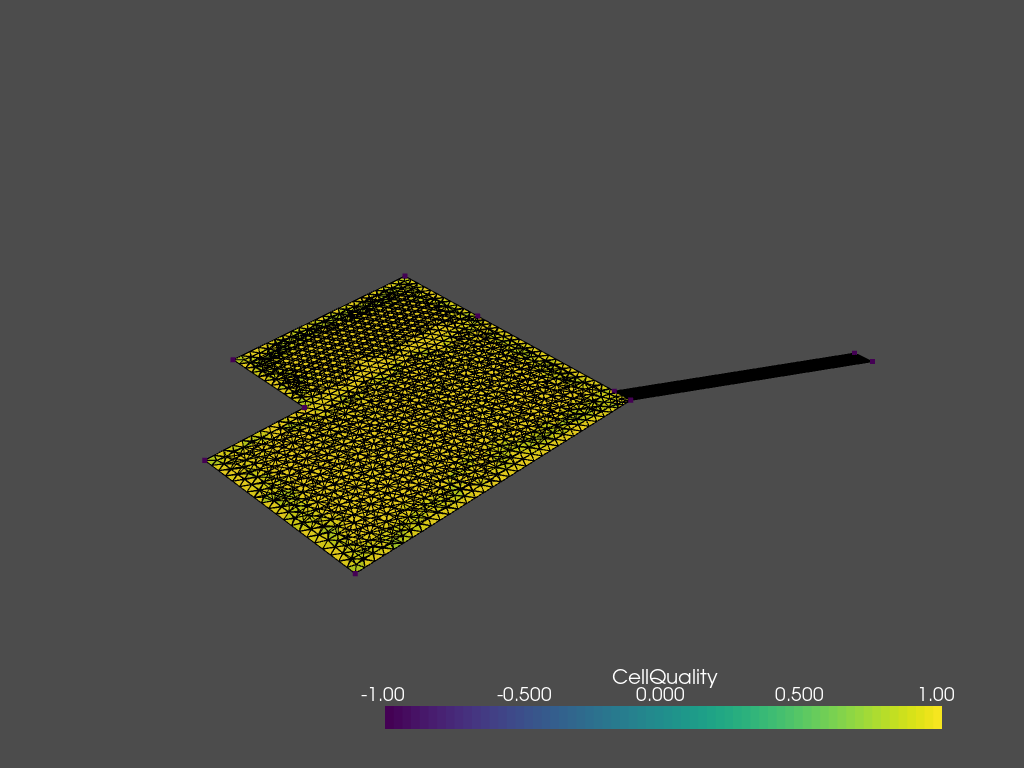

In [12]:
import warnings
warnings.filterwarnings('ignore')
Dibujar(datos_geo, lamela, size.children[0].value, general['Solid']['Tamaño de partícula medio [um]'])

La malla desarrollada presenta las siguientes características:

In [13]:
import pyvista as pv
res_malla = pv.read("out.vtk")
res_malla

UnstructuredGrid,Information
N Cells,12429
N Points,5894
X Bounds,"-2.598e+01, 4.050e+01"
Y Bounds,"0.000e+00, 5.350e+01"
Z Bounds,"0.000e+00, 2.500e-02"
N Arrays,0


## 4.3. Condiciones de frontera

Como se aprecia en la Figura , el volumen de control presenta una _entrada_ y una _salida_. También cuenta con una zona de lodos, en donde se deposita parte del material particulado que se busca separar. Las condiciones de frontera, que son tanto de tipo _Dirichlet_ y _Neumann_, se pueden apreciar a continuación.


In [14]:
from App.CFD_DEM.CF import *
Condiciones(lamela['V_L'])

|__Zona__|__Propiedad__|__Valor__|__Tipo__|
|--------|-------------|--------|-----------|
|_Entrada_| Velocidad $[cm/h]$ |0.074 |Neumann|
|_Salida_ | Presión $[KPa]$    | 101.325| Dirichlet|
        

## 4.4. Desarrollo de la simulación

La simulación numérica a realizar comprende dos métodos numéricos: el método de _volúmenes finitos_ (FVM, por sus siglas en inglés), con el cual se predice el comportamiento fluidodinámico dentro del volumen de control, y el método de _elementos discretos_ (DEM, por sus siglas en inglés), con el que se predice el comportamiento dinámico de las partículas sólidas y su interacción con el solvente.

### 4.4.1. CFD
La _Dinámica de Fluidos Computacional_ (CFD) es una herramienta computacional ampliamente usada en ingeniería para el desarrollo de simulaciones numéricas que involucren fluidos. Emplea como método base el método de volúmenes finitos (FVM). Este método numérico transforma las ecuaciones diferenciales parciales, que representan las leyes conservativas, en ecuaciones algebraicas discretas sobre volúmenes finitos.

Como se observa en el subcapítulo 4.2., el análisis de este sistema se trata de un problema _bidimensional_ (2D); de modo que la discretización del dominio se plantea de de la siguiente forma:

<div align="center">
    <img src="Images/malla.png" style="width: 250px;" />
</div>
<div align="center">
    <i>Figura 2.</i> Discretización del dominio bidimensional.
</div>

En donde la Ecuación _general_ del problema bidimensional transitorio que se busca resolver se puede apreciar en la Ecuación \ref{2D}.

$$
\begin{equation}
    \underbrace{\rho \frac{\partial \phi}{\partial t}}_{\text{transitorio}} + \underbrace{\rho u \frac{\partial \phi}{\partial x} + \rho v \frac{\partial \phi}{\partial y}}_{\text{convectivo}} = \underbrace{ \frac{\partial}{\partial x} \left( \Gamma \frac{\partial \phi}{\partial x} \right) + \frac{\partial}{\partial y} \left( \Gamma \frac{\partial \phi}{\partial y} \right)}_{\text{difusivo}} + \underbrace{S_{\phi}}_{\text{fuente}}
    \tag{9}
    \label{2D}
\end{equation}
$$

De la Ecuación \ref{2D}: 


El _comportamiento_ fluidodinámico del problema se puede observar a continuación a través de la ejecución del siguiente algoritmo. 

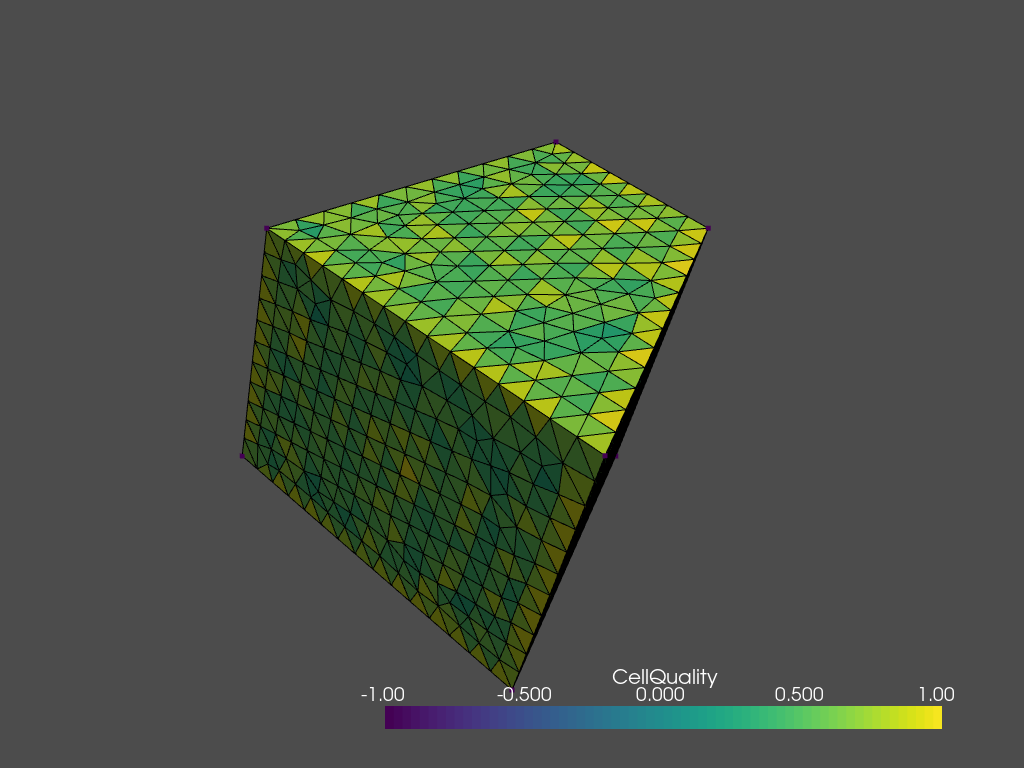

In [15]:
import pygmsh
import pyvista as pv
import os

with pygmsh.geo.Geometry() as geom:
    poly = geom.add_polygon(
        [
            [0.0, 0.0],
            [1.0, -0.2],
            [1.1, 1.2],
            [0.1, 0.7],
        ],
        mesh_size=0.1,
    )
    top, volume, lat = geom.extrude(poly, [0.0, 0.3, 1.0])
    geom.add_physical(volume, label="volume")

    mesh = geom.generate_mesh()
    mesh.write( "prueba.vtk")
    mesh.write( "prueba.msh", file_format="gmsh22", binary=False)
    file = "prueba.vtk"
    saved_file = os.getcwd() + '/' + file
    dolfin = pv.read(saved_file)
    qual = dolfin.compute_cell_quality()
    #self.convertir()
    qual.plot(show_edges=True)

In [18]:
import pygmsh as pg

with pg.occ.Geometry() as geom:
    #  Points
    pts =  [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
    kps =  [geom.add_point(pt) for pt in pts]
    
    # Edges
    edges = [
        [0, 1],
        [0, 2],
        [0, 3],
        [1, 2],
        [1, 3],
        [2, 3]
    ]
    kes = [geom.add_line(*[kps[k] for k in edge]) for edge in edges]

    # Surfaces
    loop_xz = [kes[0], kes[4], -kes[2]]
    loop_xy = [kes[0], kes[3], -kes[1]]
    loop_yz = [kes[1], kes[5], -kes[2]]
    loop_xyz = [kes[3], kes[5], -kes[4]]
    loops = [loop_xz, loop_xy, loop_yz, loop_xyz]
    names = ['xz', 'xy', 'yz', 'xyz']
    kss = []
    for loop, name in zip(loops, names):
        kl = geom.add_curve_loop(loop)
        ks = geom.add_plane_surface(kl)
        kss.append(ks)
        geom.add_physical(ks, name)

    # Volume
    surf_loop = geom.add_surface_loop(kss)
    v = geom.add_volume(surf_loop)
    
    # Mesh
    mesh = geom.generate_mesh()
    mesh.write("Piramide.msh", file_format="gmsh22", binary=False)
    """
    mesh.write( "prueba2.stl", file_format="stl")
    file = "prueba2.vtk"
    saved_file = os.getcwd() + '/' + file
    dolfin = pv.read(saved_file)
    qual = dolfin.compute_cell_quality()
    #self.convertir()
    qual.plot(show_edges=True)
    """

    # Show Facets
    print('---- Surfaces')
    print(mesh.cell_sets)
    print('--- Triangular Facets on Surface xz')
    print([mesh.cells[1].data[mesh.cell_sets['xz'][1]]])

---- Surfaces
{'xz': [None, array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=uint64), None, None], 'xy': [None, array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97],
      dtype=uint64), None, None], 'yz': [None, array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146], dtype=uint64), None, None], 'xyz': [None, array([147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 16

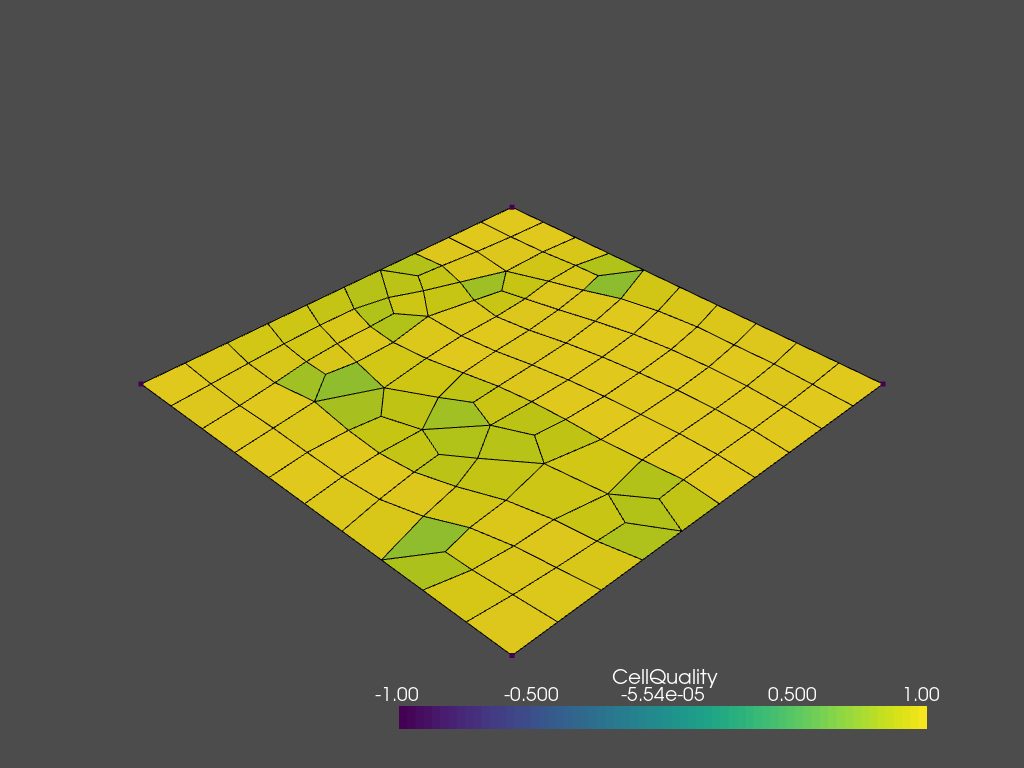

In [17]:
#from helpers import compute_volume

import pygmsh
import os


def test():
    with pygmsh.geo.Geometry() as geom:
        rectangle = geom.add_rectangle(0.0, 1.0, 0.0, 1.0, 0.0, 0.1)
        geom.set_recombined_surfaces([rectangle.surface])
        mesh = geom.generate_mesh()
        

    ref = 0.1
    #assert abs(compute_volume(mesh) - ref) < 1.0e-2 * ref
    
    mesh.write( "quads.vtk")
    file = "quads.vtk"
    saved_file = os.getcwd() + '/' + file
    dolfin = pv.read(saved_file)
    qual = dolfin.compute_cell_quality()
    #self.convertir()
    qual.plot(show_edges=True)


test()
